In [ ]:
!pip uninstall -y tensorflow && pip install tensorflow-cpu

In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv')
df = pd.DataFrame({
    'text': df['headline'],
    'label': df['sentiment']
})
df.head()

,text,label
0,Yields on CDs Fell in the Latest Week,-1
1,Currency Trading: Dollar Remains in Tight Rang...,0
2,"Stocks Fall Again; BofA, Alcoa Slide",-1
3,U.S. Dollar Falls Against Most Currencies; Dec...,-1
4,Defending Yourself Against Deflation,-1


label
 1    418
-1    418
 0    418
Name: count, dtype: int64


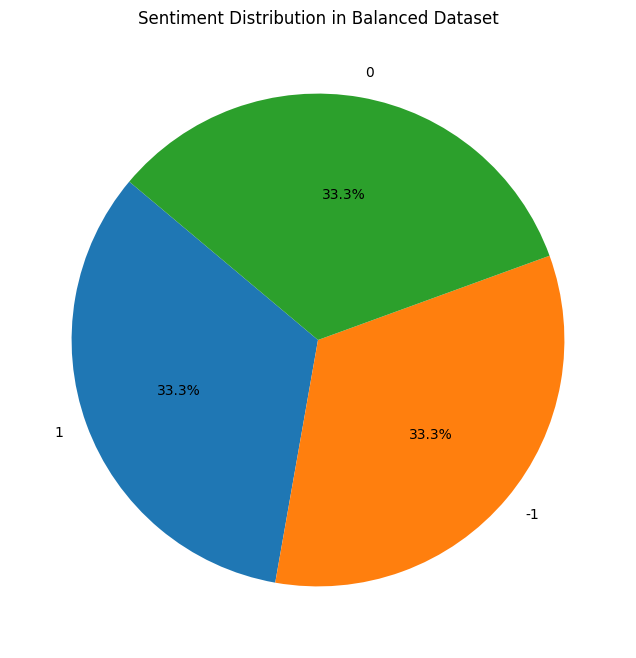

In [4]:
# Get the counts of each sentiment class
class_counts = df['label'].value_counts()

# Ensure class balance by sampling an equal number of rows for each sentiment
target_count = class_counts.min()  # Minimum count across the classes
df_neg = df[df['label'] == -1].sample(target_count, random_state=42)
df_neutral = df[df['label'] == 0].sample(target_count, random_state=42)
df_pos = df[df['label'] == 1].sample(target_count, random_state=42)

# Combine the sampled data to create a balanced dataset
df_balanced = pd.concat([df_neg, df_neutral, df_pos])

# Shuffle the dataset to mix the classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Count the occurrences of each sentiment
sentiment_counts = df_balanced['label'].value_counts()
print(sentiment_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Balanced Dataset')
plt.show()


In [5]:
class FinancialNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label + 1, dtype=torch.long)  # Shift labels from [-1,0,1] to [0,1,2]
        }

In [6]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].values, df['label'].values, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = FinancialNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FinancialNewsDataset(test_texts, test_labels, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Setup device and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Calculate class weights
class_counts = np.bincount(train_labels + 1)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = F.cross_entropy(outputs.logits, labels, weight=class_weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

In [8]:
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='weighted')
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Final Test Accuracy: 0.7394
Precision: 0.7404
Recall: 0.7394
F1 Score: 0.7393


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       106
           1       0.77      0.73      0.75        99
           2       0.74      0.71      0.72        79

    accuracy                           0.74       284
   macro avg       0.74      0.74      0.74       284
weighted avg       0.74      0.74      0.74       284


Overall Metrics:
Accuracy: 0.7394
Precision: 0.7404
Recall: 0.7394
F1 Score: 0.7393


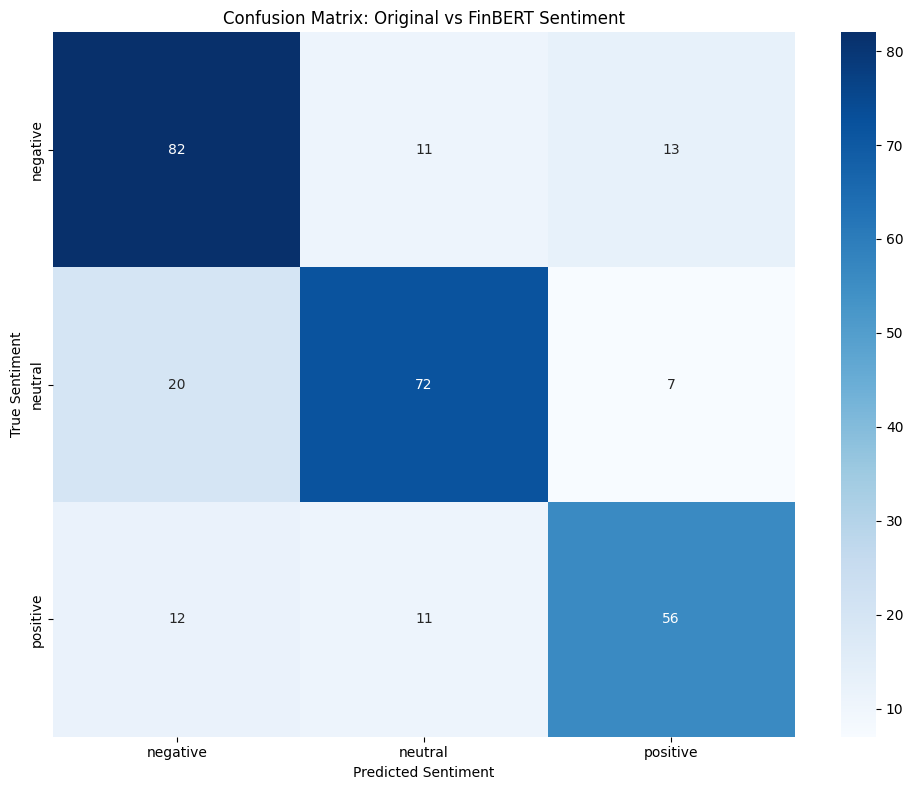

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
# Generate detailed classification report
print("Detailed Classification Report:")
print(classification_report(test_true, test_preds))

# Compute additional metrics
accuracy = accuracy_score(test_true, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='weighted')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_true, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix: Original vs FinBERT Sentiment')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.tight_layout()
plt.show()